In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import normalize_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

# Load and Prepare Dataset

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

def __jday_convert(x):
    '''
    Algorithm from python-sgp4:

    from sgp4.functions import jday
    jday(x.year, x.month, x.day, x.hour, x.minute, x.second + x.microsecond * 1e-6)
    '''
    jd = (367.0 * x.year
         - 7 * (x.year + ((x.month + 9) // 12.0)) * 0.25 // 1.0
           + 275 * x.month / 9.0 // 1.0
           + x.day
         + 1721013.5)
    fr = (x.second + (x.microsecond * 1e-6) + x.minute * 60.0 + x.hour * 3600.0) / 86400.0;
    return jd, fr

# Load Data
# orig_df = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/tims/sample2_test.pkl') # local
orig_df = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample2_test.pkl') #nellodee
# orig_df = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/secret_test.pkl')  # Very slow

# Normalize
df = normalize_data.normalize_all_columns(orig_df.copy()).dropna()

# Split into X,y
ref, X, y = get_ref_X_y(df)

# Limit y columns
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE',
          'y_ARG_OF_PERICENTER', 'y_MEAN_ANOMALY', 'y_BSTAR']
y=y[y_cols]

# Load Models and Make Predictions

In [3]:
from dataset import Dataset, to_device

def predict_one_feature(model, X, y, device='cpu'):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        to_device(model, pyt_device)
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = model(inputs)
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = model(X_tensor).detach().numpy()

    return nn_results

def load_model(name,path='models'):
    print(f"{path}/{name}.pth")
    cp = torch.load(f"{path}/{name}.pth")
    return cp['net']


def predict(X, y_cols, device="cpu"):
    pred_data = {}
    y_dummy=pd.DataFrame(np.zeros(len(X)))

    for col in y_cols:
        pred_data[col] = predict_one_feature(load_model(col), X, y_dummy, device=device).reshape(-1)

    y_pred = pd.DataFrame(pred_data)
    return y_pred

y_pred = predict(X, y_cols)

models/y_INCLINATION.pth
models/y_ECCENTRICITY.pth
models/y_MEAN_MOTION.pth
models/y_RA_OF_ASC_NODE.pth
models/y_ARG_OF_PERICENTER.pth
models/y_MEAN_ANOMALY.pth
models/y_BSTAR.pth


In [4]:
y_pred

,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE,y_ARG_OF_PERICENTER,y_MEAN_ANOMALY,y_BSTAR
0,0.346151828766,0.243981897831,0.285085886717,0.609422326088,0.854448795319,0.145606547594,0.006807656493
1,0.346237033606,0.244438156486,0.285109877586,0.596476972103,0.855224788189,0.156709372997,0.004754745867
2,0.346234053373,0.243833094835,0.285177558661,0.563235104084,0.858351349831,0.145568788052,0.002518426161
3,0.346229463816,0.243758410215,0.285210013390,0.547836184502,0.858598887920,0.201109349728,0.002399447840
4,0.346220582724,0.243783548474,0.285237610340,0.533457100391,0.857884585857,0.301094442606,0.002380982740
...,...,...,...,...,...,...,...
1263166,0.294398725033,0.004117707722,0.552359104156,-0.050993546844,0.242603391409,2.299838542938,0.000188201317
1263167,0.294392824173,0.004082622472,0.552628874779,-0.074342116714,0.245778590441,2.508927345276,0.000201104936
1263168,0.294393479824,0.004055466969,0.552957594395,-0.079654648900,0.253641873598,2.486508131027,0.000195970817
1263169,0.294394373894,0.003987531178,0.553381502628,-0.087910264730,0.262328773737,2.474975109100,0.000214192201


In [5]:
def denormalize_inputs(indf):
    df = indf.copy()
    df = normalize_data.normalize_all_columns(df, reverse=True)
    df.columns = ['INCLINATION', 'ECCENTRICITY', 'MEAN_MOTION','RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY','BSTAR']
    return df

def denormalize_predictions(indf):
    scols = ['y_INCLINATION','y_ECCENTRICITY','y_MEAN_MOTION','y_RA_OF_ASC_NODE','y_ARG_OF_PERICENTER','y_BSTAR']
    df = indf.copy()
    df.columns = ['y_INCLINATION','y_ECCENTRICITY','y_MEAN_MOTION','y_RA_OF_ASC_NODE','y_ARG_OF_PERICENTER','y_MEAN_ANOMALY','y_BSTAR']
    df[scols] = normalize_data.normalize_all_columns(df[scols].copy(), reverse=True)
    df['y_MEAN_ANOMALY'] = (y_pred.y_MEAN_ANOMALY * 90 * 360) %360
    df.columns = ['INCLINATION', 'ECCENTRICITY', 'MEAN_MOTION','RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY','BSTAR']
    return df

# def denormalize_predictions(indf):
#     indf = indf.copy()
#     d360 = ['y_ARG_OF_PERICENTER','y_RA_OF_ASC_NODE','y_MEAN_ANOMALY']
#     indf['y_MEAN_ANOMALY'] = normalize_data.normalize(indf['y_MEAN_ANOMALY'],min=0,max=90,reverse=True)
#     indf[d360] = normalize_data.normalize(indf[d360],min=0,max=360,reverse=True)
#     indf[d360] = indf[d360]%360
#     indf['y_INCLINATION'] = normalize_data.normalize(indf['y_INCLINATION'],min=0,max=180,reverse=True)
#     indf['y_INCLINATION'] = indf['y_INCLINATION']%180
#     indf['y_ECCENTRICITY'] = normalize_data.normalize(indf['y_ECCENTRICITY'],min=0,max=0.25,reverse=True)
#     indf['y_MEAN_MOTION'] = normalize_data.normalize(indf['y_MEAN_MOTION'],min=11.25,max=20,reverse=True)
#     indf.name="Predictions"
#     indf.columns = ['INCLINATION', 'ECCENTRICITY', 'MEAN_MOTION','RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY','BSTAR']
#     return indf

y_pred_dn = denormalize_predictions(y_pred.copy())
y_dn = denormalize_predictions(y.copy())
y_cols_dn = list(y_dn.columns)

In [6]:
X_pred_dn = X[['X_INCLINATION_1', 'X_ECCENTRICITY_1', 'X_MEAN_MOTION_1','X_RA_OF_ASC_NODE_1', 'X_ARG_OF_PERICENTER_1', 'X_MEAN_ANOMALY_1','X_BSTAR_1']]
X_pred_dn = denormalize_inputs(X_pred_dn)
X_pred_dn

,INCLINATION,ECCENTRICITY,MEAN_MOTION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,BSTAR
0,62.2997,0.0609921,13.74359934,224.1240,317.7028,37.8433,0.00692640
1,62.3151,0.0611064,13.74380921,219.6323,318.0523,37.4637,0.00487400
2,62.3145,0.0609549,13.74440143,207.5045,319.1130,36.5645,0.00263790
3,62.3140,0.0609374,13.74468523,202.7807,319.5205,36.1868,0.00251870
4,62.3130,0.0609458,13.74492715,199.0845,319.8403,35.9051,0.00250030
...,...,...,...,...,...,...,...
1263166,52.9949,0.0010644,16.08224212,46.5308,108.0130,252.2063,0.00030590
1263167,52.9949,0.0010594,16.08460267,44.2525,110.1984,250.0188,0.00031888
1263168,52.9949,0.0010522,16.08747856,41.6491,112.9203,247.2941,0.00031369
1263169,52.9950,0.0010350,16.09118805,38.3932,115.9803,244.2297,0.00033193


# Compare Ground Truth to Predicted

In [7]:
# Show norads with least and most TLEs
ref.groupby('__NORAD_CAT_ID_1')['__GP_ID_1'].count().sort_values().reset_index().to_numpy()[[0,-1]]

array([[ 38539,    125],
       [ 12701, 166837]])

In [8]:
def plot_norad_test_outputs(norad,ref,y,y_pred,y_cols,subtext='',kind='line',**kwargs):
    if kind == 'scatter':
        fig = plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext,**kwargs)
        return fig
        
    mask = ref.__NORAD_CAT_ID_1 == norad
    n = len(y_cols)

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['__EPOCH_2']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    y_test_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,0], xlabel='',kind=kind, **kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['__EPOCH_2']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    y_pred_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,1], xlabel='',kind=kind, **kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

def plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext='',**kwargs):
    mask = ref.__NORAD_CAT_ID_1 == norad
    n = len(y_cols)
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['__EPOCH_2']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_test_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,0],xlabel='',label=col,color=colors[i],**kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['__EPOCH_2']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_pred_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,1],xlabel='',label=col,color=colors[i],**kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

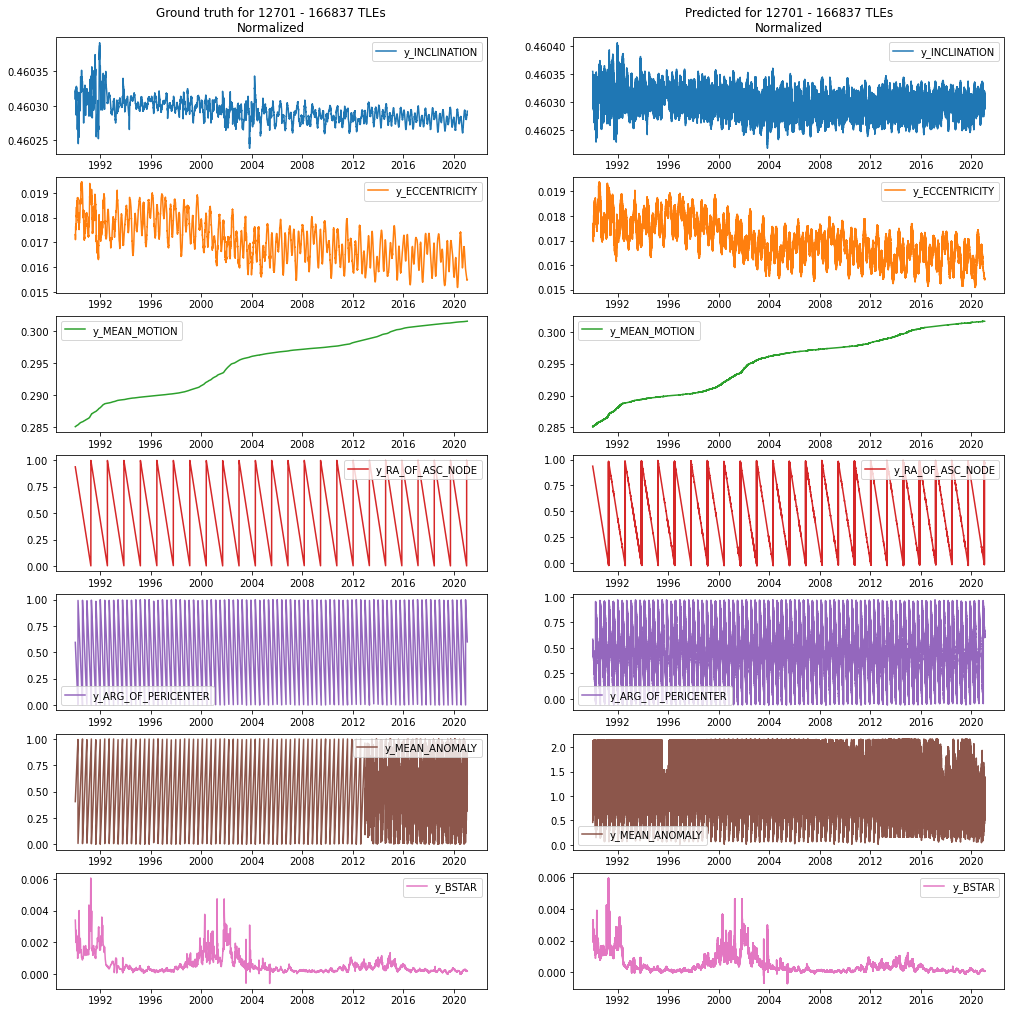

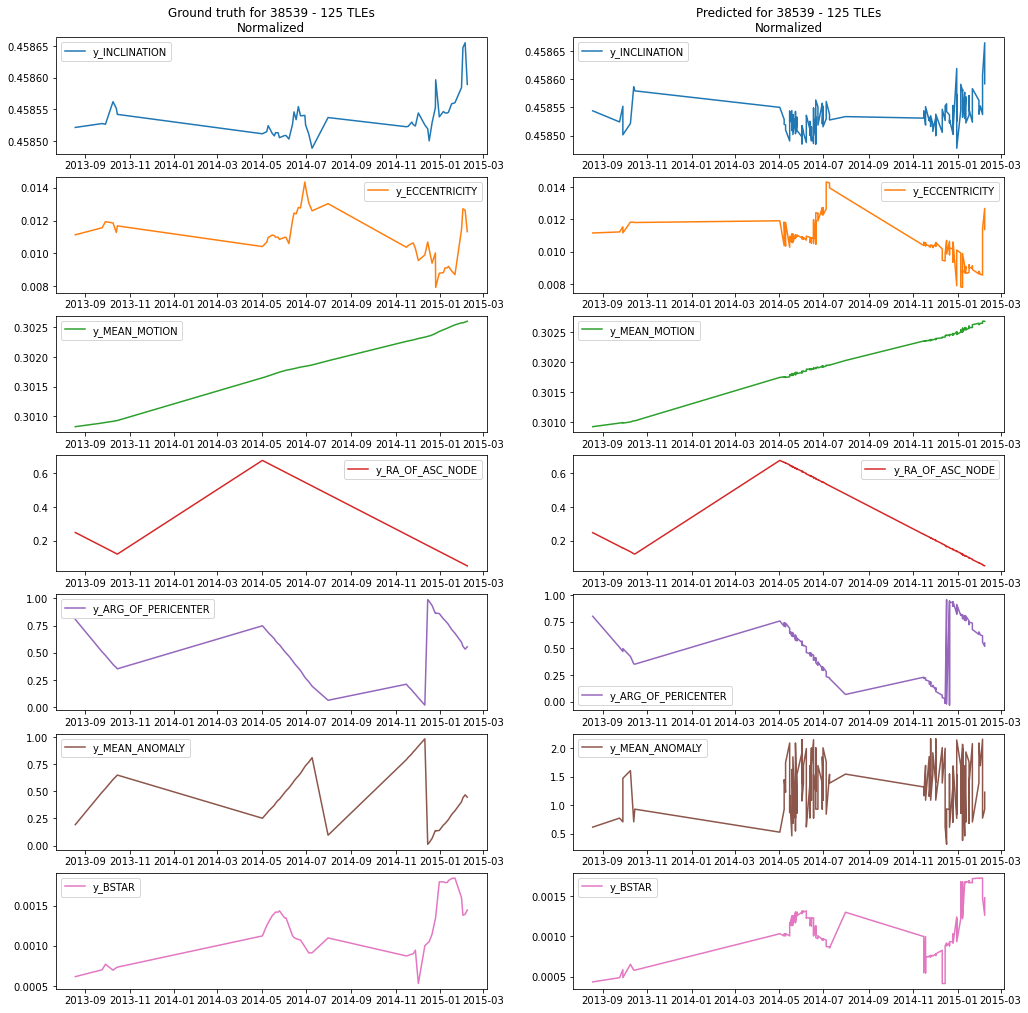

In [9]:
fig = plot_norad_test_outputs(12701,ref,y,y_pred,y_cols,'Normalized')
plt.show()

fig = plot_norad_test_outputs(38539,ref,y,y_pred,y_cols,'Normalized')
plt.show()

### Zoomed into 1 year

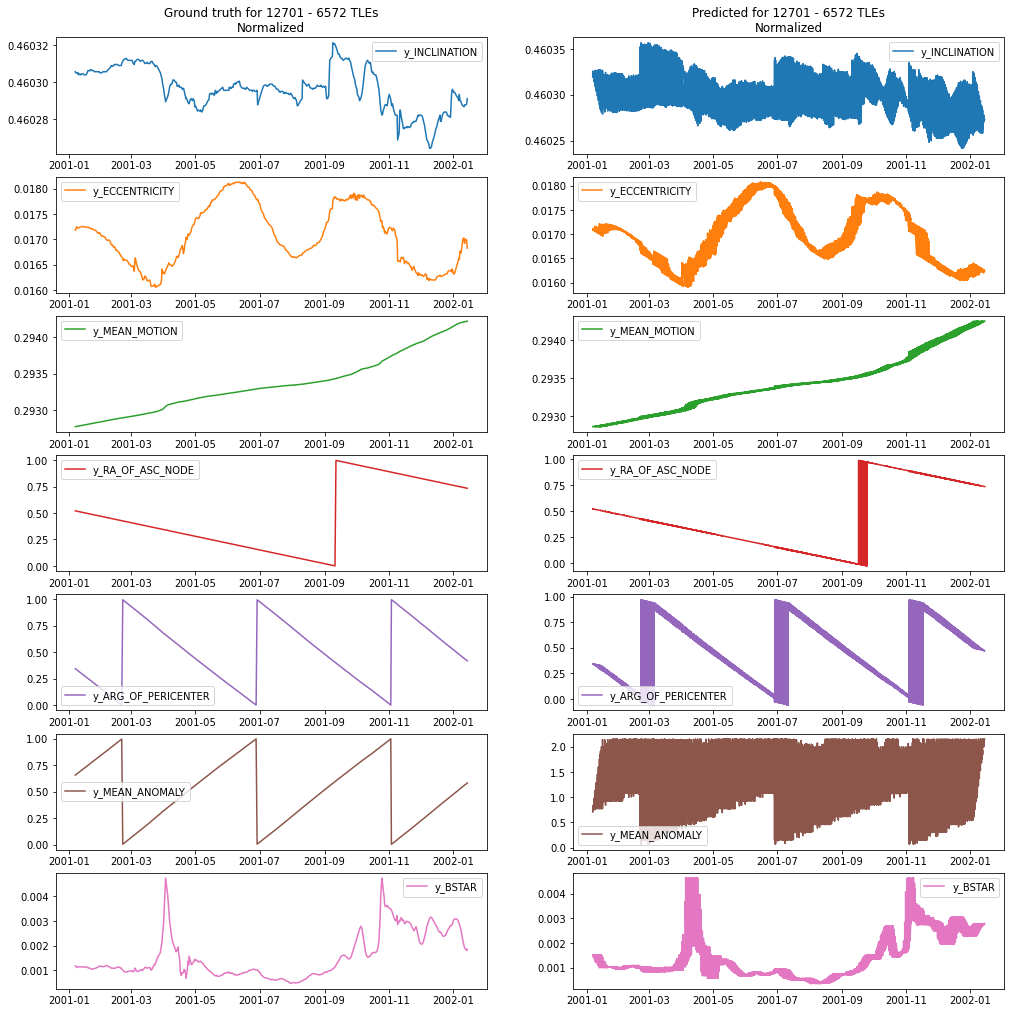

In [10]:
period_y2001_mask = ref.__EPOCH_1.between(pd.Timestamp(2001,1,1),pd.Timestamp(2002,1,1))
ref_y2001 = ref[period_y2001_mask].copy()
X_y2001 = X[period_y2001_mask].copy()
y_y2001 = y[period_y2001_mask].copy()
y_pred_y2001 = y_pred[period_y2001_mask].copy()
fig = plot_norad_test_outputs(12701,ref_y2001,y_y2001,y_pred_y2001,y_cols,'Normalized')
plt.show()

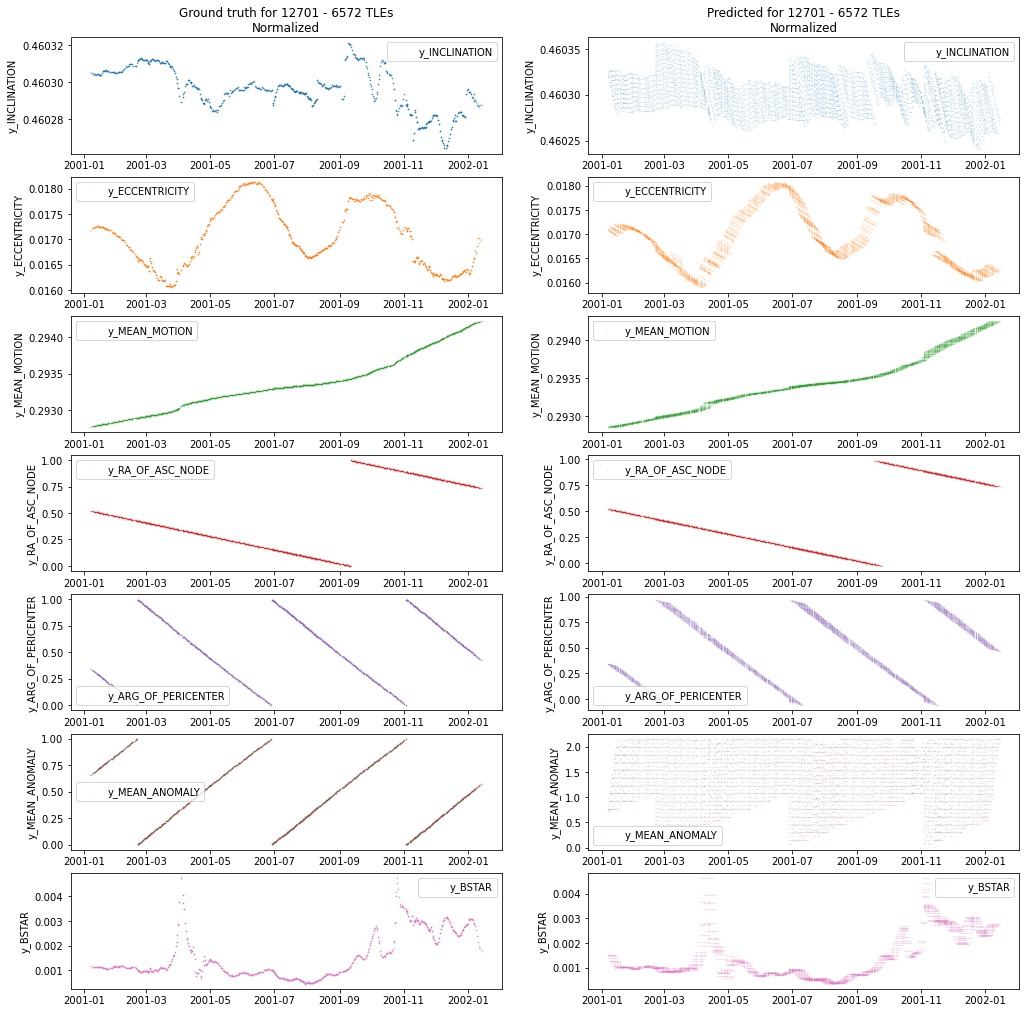

In [11]:
fig = plot_norad_test_outputs(12701,ref_y2001,y_y2001,y_pred_y2001,y_cols,'Normalized',kind='scatter',alpha=0.2,s=0.1)
plt.show()

### Zoomed into 30 days

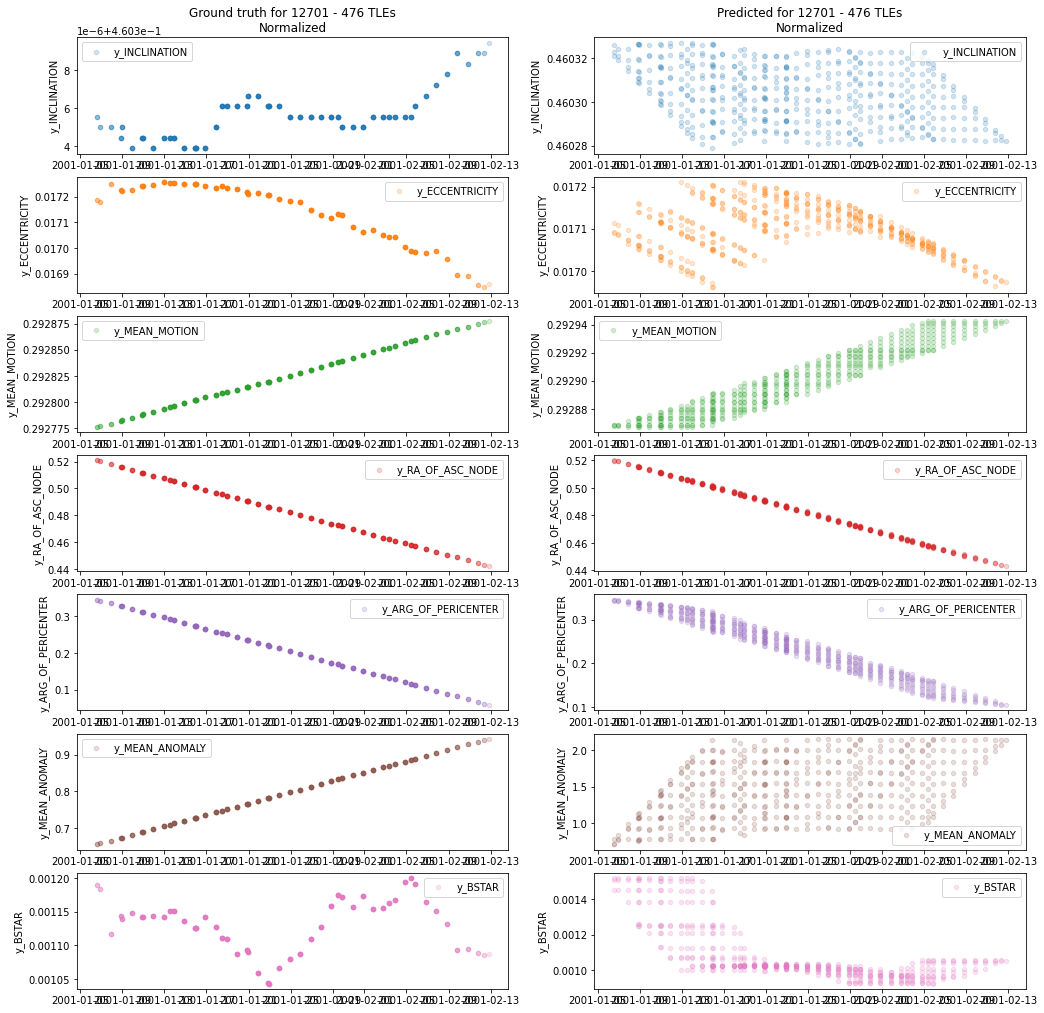

In [12]:
period_30d_mask = ref.__EPOCH_1.between(pd.Timestamp(2001,1,1),pd.Timestamp(2001,1,30))
ref_30d = ref[period_30d_mask].copy()
X_30d = X[period_30d_mask].copy()
y_30d = y[period_30d_mask].copy()
y_pred_30d = y_pred[period_30d_mask].copy()
fig = plot_norad_test_outputs(12701,ref_30d,y_30d,y_pred_30d,y_cols,'Normalized',kind='scatter',alpha=0.2)
plt.show()

### Compare Predictions to their X inputs

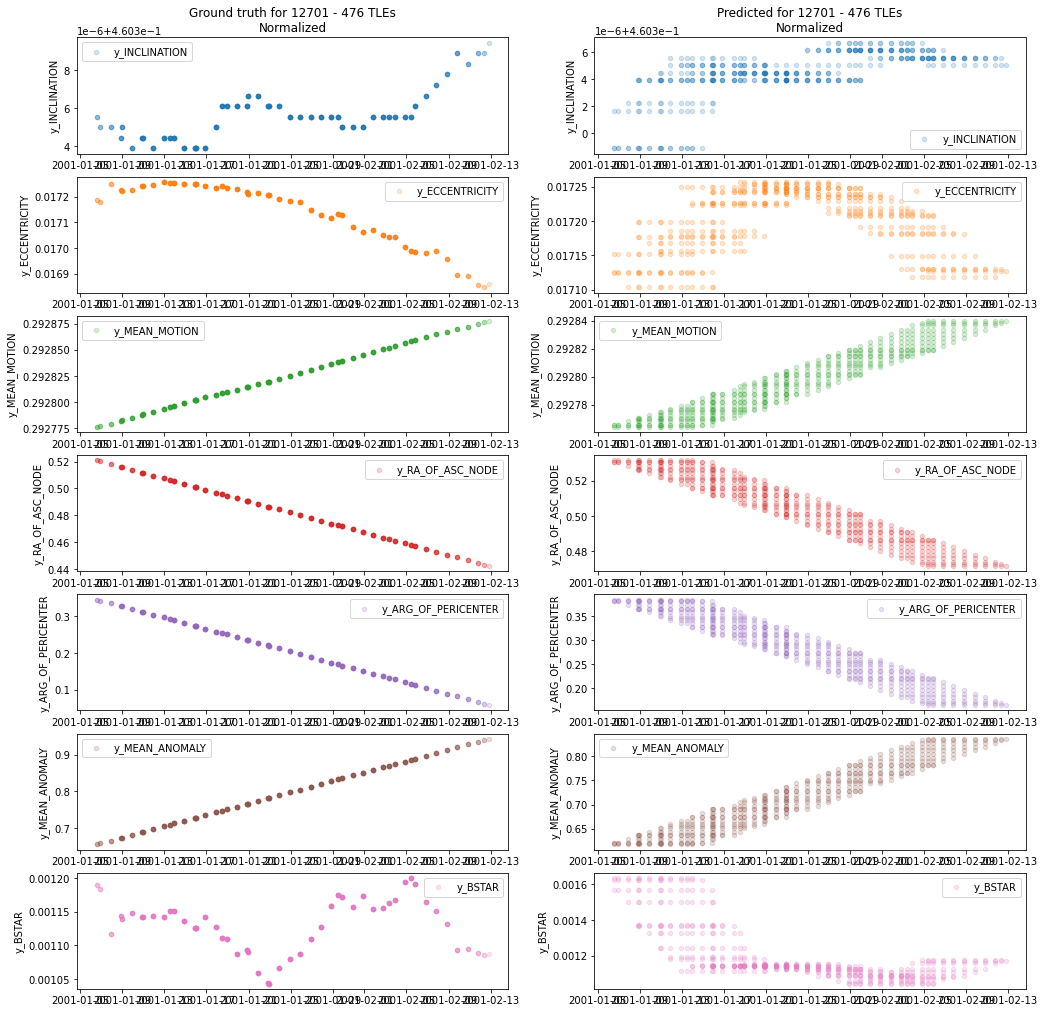

In [13]:
x_cols = ['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1',
          'X_RA_OF_ASC_NODE_1','X_ARG_OF_PERICENTER_1',
          'X_MEAN_ANOMALY_1','X_BSTAR_1']
y_pred_X30d = y_pred_30d.copy()
y_pred_X30d[y_cols] = X_30d[x_cols]
fig = plot_norad_test_outputs(12701,ref_30d,y_30d,y_pred_X30d,y_cols,'Normalized',kind='scatter',alpha=0.2)
plt.show()

### Compare the errors between Prediction and X

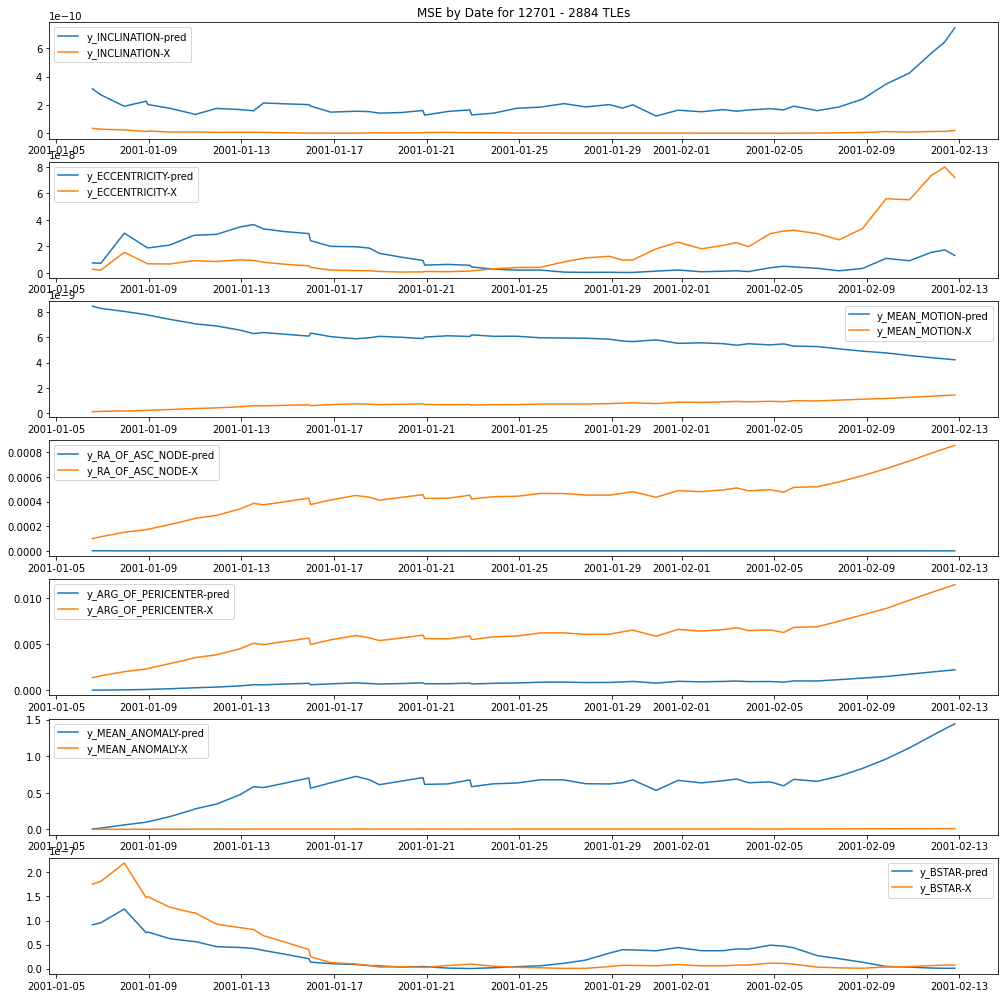

In [14]:
def get_mse(norad,ref,y,y_pred,y_cols):
    mask = ref.__NORAD_CAT_ID_1 == norad
    n = len(y_cols)
    y_se = ((y-y_pred)**2)[mask].copy()
    y_se['EPOCH'] = ref[mask]['__EPOCH_2']
    y_se = y_se.set_index('EPOCH')
    y_mse = (y_se.groupby(level=0).sum() / y_se.groupby(level=0).count())
    return y_mse
    
def plot_mse(norad,ref,y,y_pred,y_pred_X,y_cols):
    n = len(y_cols)
    fig, axs = plt.subplots(n,1,figsize=(17,n*2.5))

    y_mse = get_mse(norad,ref,y,y_pred,y_cols).reset_index()
    y_mseX = get_mse(norad,ref,y,y_pred_X,y_cols).reset_index()
    
    for i,col in enumerate(y_cols):
        axs[i].plot(y_mse['EPOCH'],y_mse[col],label=f'{col}-pred')
        axs[i].plot(y_mseX['EPOCH'],y_mseX[col],label=f'{col}-X')
        axs[i].legend()
        
    axs[0].set_title(f'MSE by Date for {norad} - {len(y_pred)} TLEs')
    return fig

fig = plot_mse(12701,ref_30d,y_30d,y_pred_30d,y_pred_X30d,y_cols)
plt.show()

### Comparison if data is denomarlized

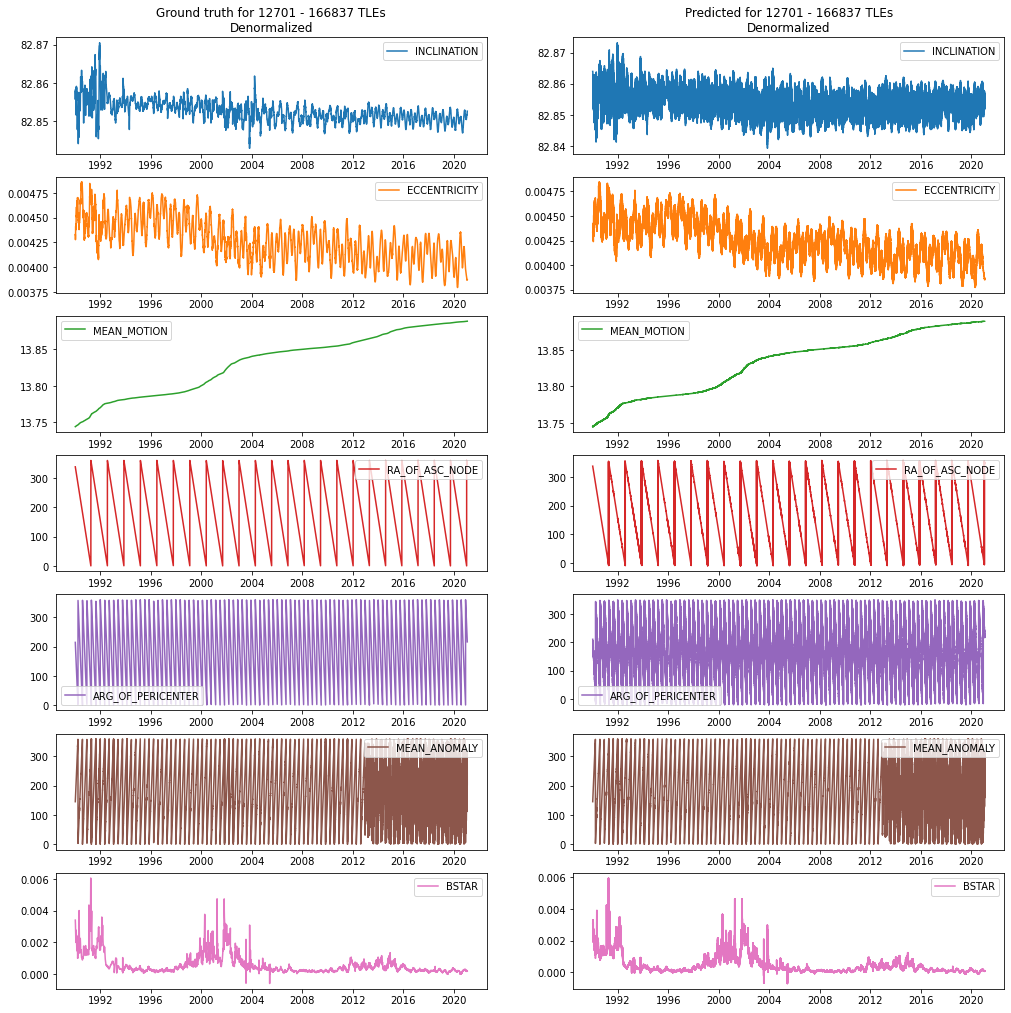

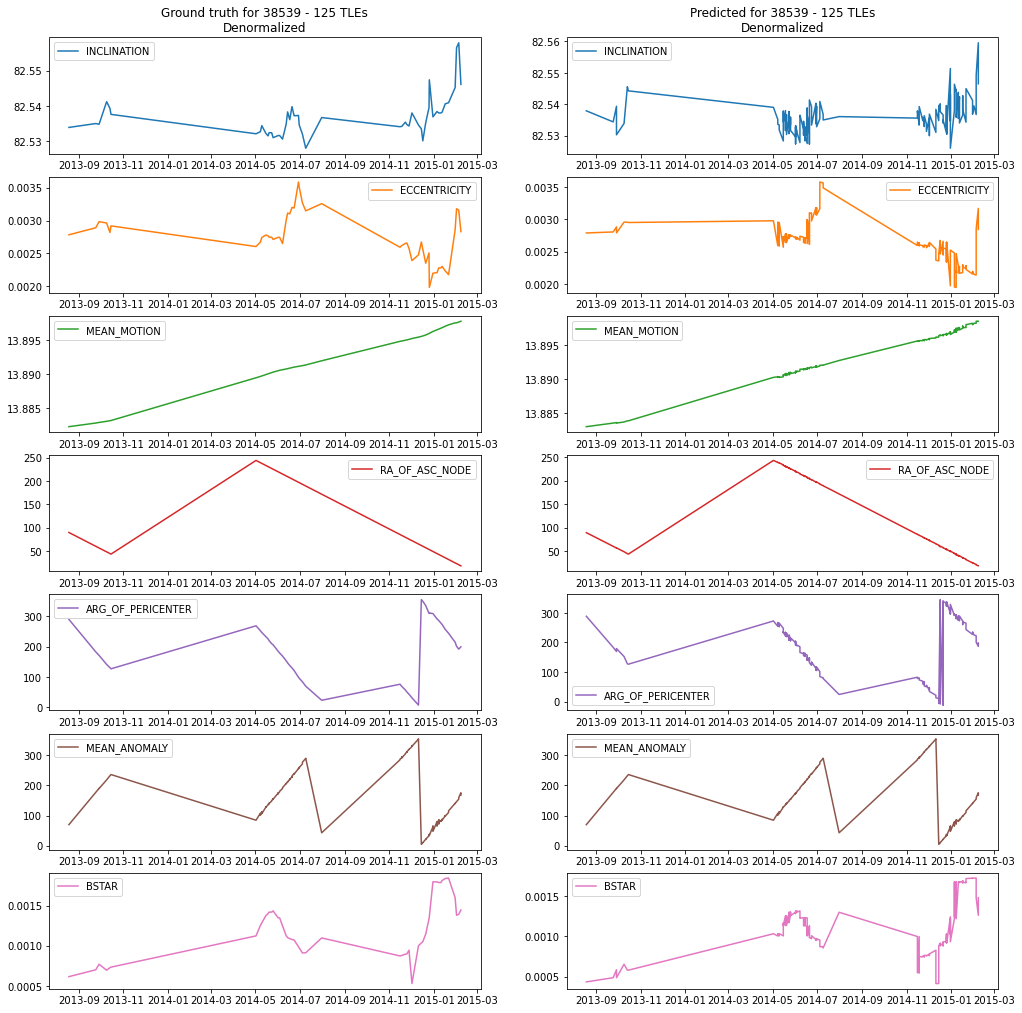

In [15]:
# These are in sample test:
fig = plot_norad_test_outputs(12701,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
plt.show()

fig = plot_norad_test_outputs(38539,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
plt.show()

# Predict For Gaps

models/y_INCLINATION.pth
models/y_ECCENTRICITY.pth
models/y_MEAN_MOTION.pth
models/y_RA_OF_ASC_NODE.pth
models/y_ARG_OF_PERICENTER.pth
models/y_MEAN_ANOMALY.pth
models/y_BSTAR.pth
models/y_INCLINATION.pth
models/y_ECCENTRICITY.pth
models/y_MEAN_MOTION.pth
models/y_RA_OF_ASC_NODE.pth
models/y_ARG_OF_PERICENTER.pth
models/y_MEAN_ANOMALY.pth
models/y_BSTAR.pth


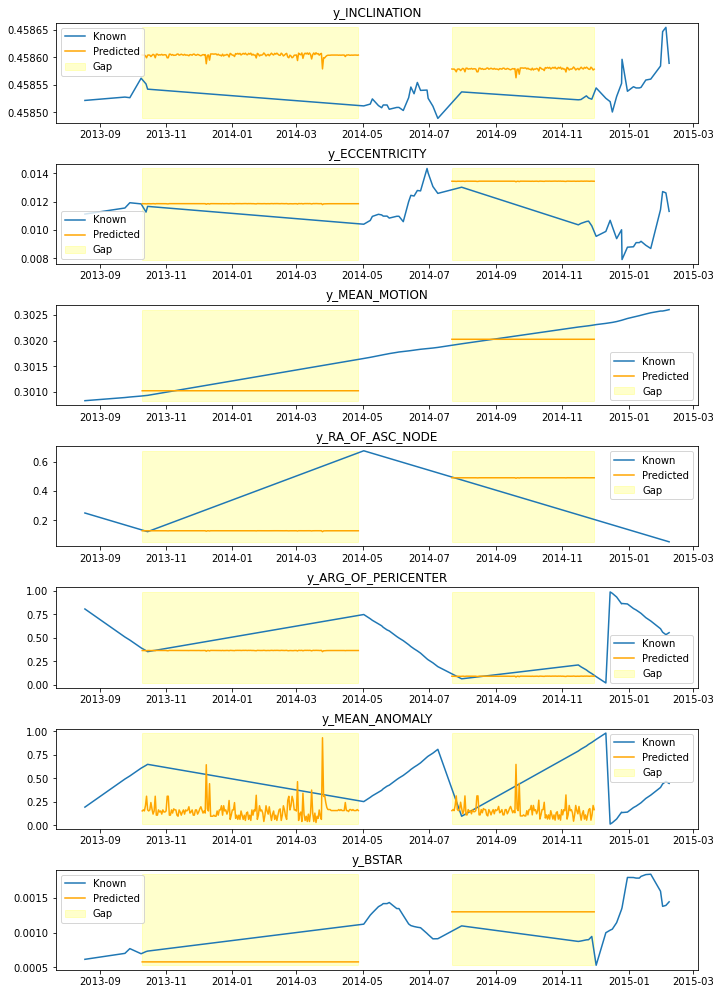

In [16]:
def find_gaps(ref, norad, days):
    # Find gaps of 100 days or more
    diff = ref[ref.__NORAD_CAT_ID_1 == norad].__EPOCH_2.diff(-1)
    diff = diff[diff < -pd.Timedelta(f'{days}d')]
    diff = list(zip(diff.index,diff.index+1))
    dt_pairs = [ref.loc[list(idxs)] for idxs in diff]
    return dt_pairs

def predict_gaps(ref, X, dt_pairs):
    y_gaps = []

    for j, dt_pair in enumerate(dt_pairs):
        # Create a list of epochs to predict
        buffer = pd.Timedelta('1d')  # buffer before and after known TLE
        dt_range = pd.date_range(dt_pair.__EPOCH_1.iloc[0] + buffer, dt_pair.__EPOCH_1.iloc[1] - buffer, freq='1d')

        # Create the ref dataframe for the gap
        ref_gap = dt_pair.iloc[[0]].append([dt_pair.iloc[0]]*(len(dt_range)-1), ignore_index=True)
        ref_gap['__EPOCH_2'] = dt_range

        # Create the X dataframe for the gap
        X_gap = X.iloc[[dt_pair.index[0]]].append([X.iloc[dt_pair.index[0]]]*(len(dt_range)-1), ignore_index=True)

        # Copy the EPOCH2 from ref
        X_gap[['X_EPOCH_JD_2','X_EPOCH_FR_2']] = ref_gap.__EPOCH_2.apply(__jday_convert).to_list()
        X_gap[['X_EPOCH_JD_2','X_EPOCH_FR_2']] = normalize_data.normalize_all_columns(X_gap[['X_EPOCH_JD_2','X_EPOCH_FR_2']].copy())

        # Recalculate the delta
        #X_gap['X_delta_EPOCH'] = (ref_gap.__EPOCH_2 - ref_gap.__EPOCH_1).astype(int) / 86400000000000 # in days
        X_gap['X_delta_EPOCH'] = (ref.__EPOCH_2 - ref.__EPOCH_1)/ np.timedelta64(1, 'ns') / 86400000000000

        # Renormalize the delta
        X_gap['X_delta_EPOCH'] = normalize_data.normalize_all_columns(X_gap[['X_delta_EPOCH']].copy())

        # Preform prediction on X
        y_gap = predict(X_gap, y_cols)

        # Add the epoch
        y_gap['EPOCH'] = ref_gap['__EPOCH_2']
        
        # Add the gap to the list
        y_gaps.append(y_gap)
        
    return y_gaps

def plot_gaps(norad, y_gaps, y, y_cols):
    # Setup the Figure
    mask = ref.__NORAD_CAT_ID_1 == norad
    n = len(y_cols)
    y_known = y[mask].copy()
    y_known['EPOCH'] = ref[mask]['__EPOCH_2']
    y_known_s = y_known.sort_values(by='EPOCH')
    fig, axs = plt.subplots(n,1,figsize=(10,n*2))
    fig.tight_layout(pad=2.0)

    # Add known data to Figure
    for i, col in enumerate(y_cols):
        axs[i].plot(y_known_s.EPOCH, y_known_s[col], label='Known')

    for j, y_gap in enumerate(y_gaps):
        for i, col in enumerate(y_cols):
            label_pred = 'Predicted' if j==0 else None
            label_gap = 'Gap' if j==0 else None

            axs[i].plot(y_gap.EPOCH, y_gap[col], color='orange', label=label_pred)
            axs[i].set_title(col)
            bottom=min(min(c[col]) for c in [y_known_s,y_gap])
            height=max(max(c[col]) for c in [y_known_s,y_gap])-bottom
            width = max(y_gap.EPOCH)-min(y_gap.EPOCH)
            axs[i].add_patch(Rectangle((min(y_gap.EPOCH),bottom), width, height, color='yellow',alpha=0.2, label=label_gap))
            axs[i].legend()
    return fig
    
    
# Find the gaps in the TLE data for a NORAD

norad = 38539
gap_size_in_days=100

dt_pairs = find_gaps(ref, norad=norad, days=gap_size_in_days)
y_gaps = predict_gaps(ref, X, dt_pairs)
fig = plot_gaps(norad, y_gaps, y, y_cols)
plt.show()

# Visualizing the Mean Squared Error

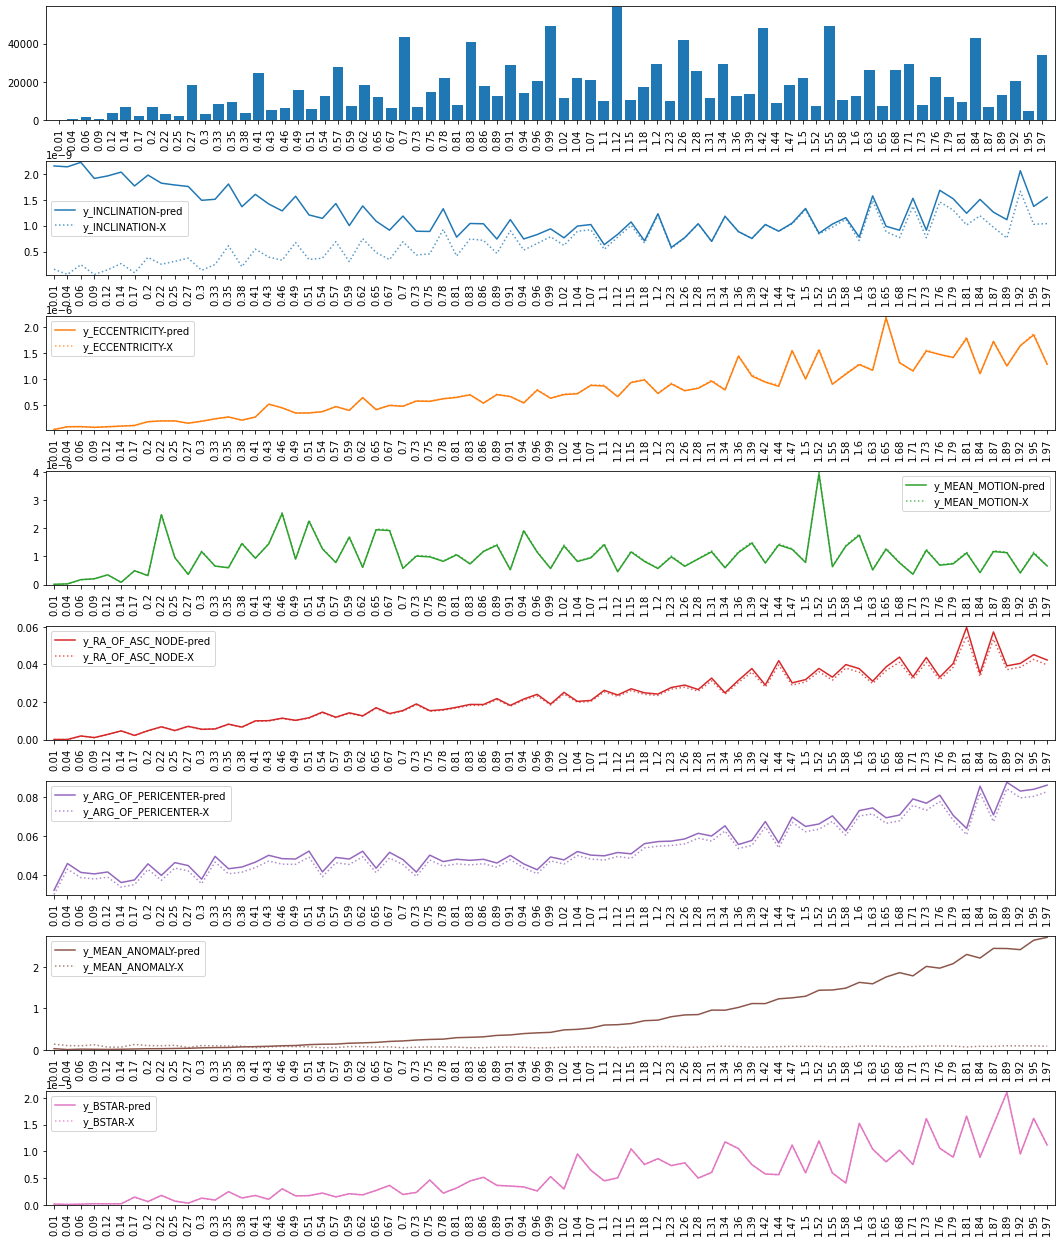

In [17]:
def plot_mse_by_epoch_diff_vs_x():
    bins=75
    n = len(y_cols)
    colors1=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
    colors2=['blue','orange','green','red','purple','brown','pink']
    fig, axs = plt.subplots(n+1,1,figsize=(15,n*2.5))
    fig.tight_layout(pad=2.0)
    
    y_pred_X = y_pred.copy()
    y_pred_X[y_cols] = X[x_cols]

    epoch_delta_count, bins = pd.cut(X.X_delta_EPOCH, bins=bins, labels=range(bins), retbins=True)
    epoch_delta_count = epoch_delta_count.reset_index()
    epoch_delta_count['X_labels']=epoch_delta_count['X_delta_EPOCH'].map({i:b for i,b in enumerate(bins)})
    xticks=[round(v, 2)for v in sorted(epoch_delta_count['X_labels'].unique())]
    by_count = epoch_delta_count.groupby('X_delta_EPOCH').count()['index']
    axs[0].bar(by_count.index, by_count)

    y_pred_se = (y-y_pred)**2
    y_pred_se['X_delta_EPOCH'] = epoch_delta_count['X_delta_EPOCH']
    y_pred_se.set_index('X_delta_EPOCH', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],color=colors1[i],label=f'{col}-pred')
    
    y_pred_se = (y-y_pred_X)**2
    y_pred_se['X_delta_EPOCH'] = epoch_delta_count['X_delta_EPOCH']
    y_pred_se.set_index('X_delta_EPOCH', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],':',color=colors1[i], alpha=0.75,label=f'{col}-X')
        axs[i+1].legend()
        
    for i in range(n+1):
        axs[i].margins(0.008)
        axs[i].set_xticks(sorted(epoch_delta_count['X_delta_EPOCH'].unique()))
        axs[i].set_xticklabels(xticks, rotation=90)
    
    return fig

fig = plot_mse_by_epoch_diff_vs_x()
plt.show()

In [18]:
x_cols

['X_INCLINATION_1',
 'X_ECCENTRICITY_1',
 'X_MEAN_MOTION_1',
 'X_RA_OF_ASC_NODE_1',
 'X_ARG_OF_PERICENTER_1',
 'X_MEAN_ANOMALY_1',
 'X_BSTAR_1']

In [19]:
y_pred_X = y_pred.copy()
y_pred_X[y_cols] = X[x_cols]

In [20]:
display(y_pred_X.head())
display(y_pred.head())
display(y.head())

,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE,y_ARG_OF_PERICENTER,y_MEAN_ANOMALY,y_BSTAR
0,0.346109444444,0.2439684,0.284982781714,0.622566666667,0.882507777778,0.105120277778,0.0069264
1,0.346195000000,0.2444256,0.285006766857,0.610089722222,0.883478611111,0.104065833333,0.0048740
2,0.346191666667,0.2438196,0.285074449143,0.576401388889,0.886425000000,0.101568055556,0.0026379
3,0.346188888889,0.2437496,0.285106883429,0.563279722222,0.887556944444,0.100518888889,0.0025187
4,0.346183333333,0.2437832,0.285134531429,0.553012500000,0.888445277778,0.099736388889,0.0025003


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE,y_ARG_OF_PERICENTER,y_MEAN_ANOMALY,y_BSTAR
0,0.346151828766,0.243981897831,0.285085886717,0.609422326088,0.854448795319,0.145606547594,0.006807656493
1,0.346237033606,0.244438156486,0.285109877586,0.596476972103,0.855224788189,0.156709372997,0.004754745867
2,0.346234053373,0.243833094835,0.285177558661,0.563235104084,0.858351349831,0.145568788052,0.002518426161
3,0.346229463816,0.243758410215,0.285210013390,0.547836184502,0.858598887920,0.201109349728,0.002399447840
4,0.346220582724,0.243783548474,0.285237610340,0.533457100391,0.857884585857,0.301094442606,0.002380982740


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE,y_ARG_OF_PERICENTER,y_MEAN_ANOMALY,y_BSTAR
0,0.346124444444,0.2441064,0.285024995429,0.615178055556,0.882899722222,0.104595833333,0.0065902
1,0.346181666667,0.2443600,0.285033877714,0.602100555556,0.884061944444,0.103617500000,0.0045242
2,0.346195000000,0.2437784,0.285093140571,0.568984722222,0.887070555556,0.100984444444,0.0025701
3,0.346183333333,0.2437832,0.285134531429,0.553012500000,0.888445277778,0.099736388889,0.0025003
4,0.346188888889,0.2438176,0.285174038857,0.537615833333,0.889783055556,0.098518333333,0.0024458


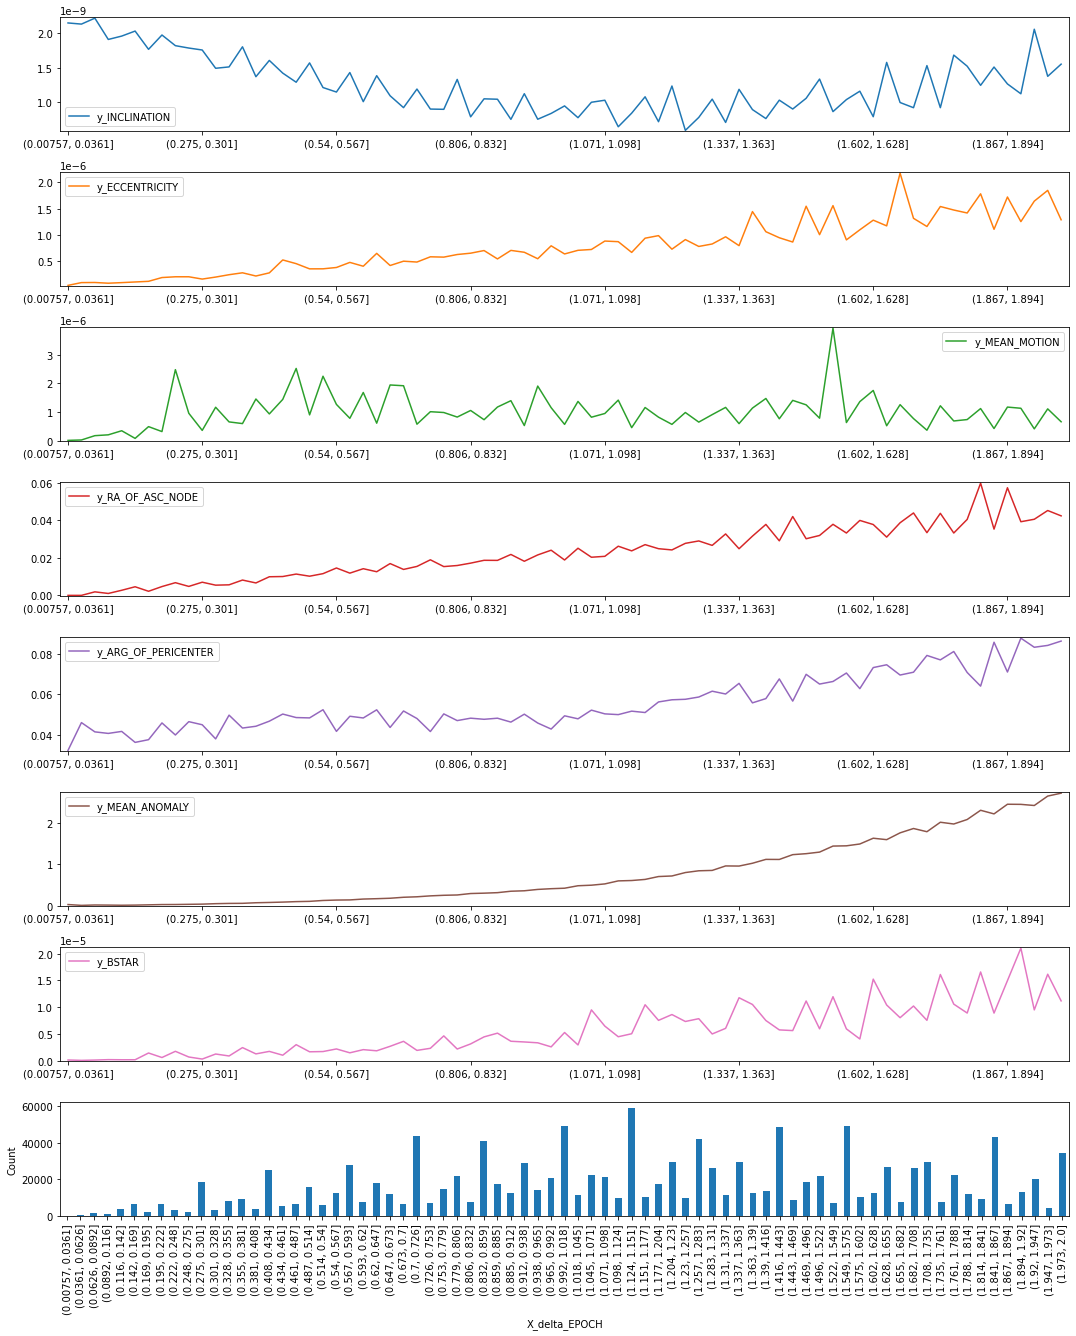

In [21]:
def plot_mse_by_epoch_diff():
    bins=75
    n = len(y_cols)
    fig, axs = plt.subplots(n+1,1,figsize=(15,n*2.5))
    fig.tight_layout(pad=2.0)
    #fig.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=None, hspace=None)

    tmp = pd.cut(X.X_delta_EPOCH, bins=bins).reset_index()
    tmp.groupby('X_delta_EPOCH').count().plot(kind='bar', legend=False, ylabel='Count', ax=axs[n])

    tmp2 = (y-y_pred)**2
    tmp2['X_delta_EPOCH'] = tmp['X_delta_EPOCH']
    tmp2.set_index('X_delta_EPOCH', inplace=True)
    (tmp2.groupby(level=0).sum() / tmp2.groupby(level=0).count()).plot(subplots=True, ax=axs[:n], xlabel='')
    
    for i in range(n):
        axs[i].margins(0.008)
    
    return fig

fig = plot_mse_by_epoch_diff()
plt.show()

# Get X,Y,Z Data

In [22]:
# y_pred_dn = y_pred_dn[['INCLINATION','ECCENTRICITY','MEAN_MOTION','RA_OF_ASC_NODE','ARG_OF_PERICENTER','MEAN_ANOMALY','BSTAR']]

In [7]:
from sgp4.api import Satrec, SatrecArray, WGS72
from datetime import datetime
tqdm.pandas()

def get_satrec_erv(bst, ecc, aop, inc, mea, mem, raa, mmdot=0, mmddot=0, norad=0, tle_epoch=None, trg_epoch=None):
    '''
    Get cartesian coordinates of a satellite based on TLE parameters

     Parameters
     ----------
     bst : float : B-star
     ecc : float : eccentricity (in degrees)
     aop : float : argument of perigee (in degrees)
     inc : float : inclination (in degrees)
     mea : float : mean anomaly (in degrees)
     mem : float : mean motion (in degrees per minute)
     raa : float : right ascension of ascending node (in degrees)
     mmdot : float : NOT USED - ballistic coefficient
     mmddot : float : NOT USED - mean motion 2nd derivative
     norad : int : NOT USED - NORAD ID
     tle_epoch : Timestamp : TLE's epoch
     trg_epoch : Timestamp : moment in time to get position

     Returns
     -------
     list
         [e, rx, ry, rz, vx, vy, yz] error, position xyz, velocity xyz.  error = 0 is good
    '''
    try:
        r = datetime.strptime('12/31/1949 00:00:00', '%m/%d/%Y %H:%M:%S')
        epoch_days = (tle_epoch-r)/np.timedelta64(1, 'D')
        s = Satrec()
        s.sgp4init(
             WGS72,           # gravity model
             'i',             # 'a' = old AFSPC mode, 'i' = improved mode
             norad,               # satnum: Satellite number
             epoch_days,       # epoch: days since 1949 December 31 00:00 UT
             bst,      # bstar: drag coefficient (/earth radii)
             mmdot,   # ndot (NOT USED): ballistic coefficient (revs/day)
             mmddot,             # nddot (NOT USED): mean motion 2nd derivative (revs/day^3)
             ecc,       # ecco: eccentricity
             aop*np.pi/180, # argpo: argument of perigee (radians)
             inc*np.pi/180, # inclo: inclination (radians)
             mea*np.pi/180, # mo: mean anomaly (radians)
             mem*np.pi/(4*180), # no_kozai: mean motion (radians/minute)
             raa*np.pi/180, # nodeo: right ascension of ascending node (radians)
        )
        jday = __jday_convert(trg_epoch)
        e,r,v = s.sgp4(*jday)
        return pd.Series([e, *r, *v])
    except Exception as e:
        raise Exception(e)
        # e is SGP4 propagation errors, i've also added error 999 for when something goes wrong
        #return pd.Series([999, 0,0,0,0,0,0])

try:
    #raise Exception('force rebuild')
    #xyz_pred = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/tims/sample2_xyz_pred.pkl') # local
    xyz_pred = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample2_xyz_pred.pkl') #nellodee
except:
    y_pred_dn = y_pred_dn.merge(ref[['__EPOCH_2']], left_index=True, right_index=True)
    predictions_sgp4 = y_pred_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.__EPOCH_2,
                                                                          trg_epoch=x.__EPOCH_2,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    y_pred_dn = y_pred_dn.merge(predictions_sgp4, left_index=True, right_index=True)

    X_pred_dn = X_pred_dn.merge(ref[['__EPOCH_1','__EPOCH_2']], left_index=True, right_index=True)
    predictions_sgp4 = X_pred_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.__EPOCH_1,
                                                                          trg_epoch=x.__EPOCH_2,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    X_pred_dn = X_pred_dn.merge(predictions_sgp4, left_index=True, right_index=True)
    
    y_dn = y_dn.merge(ref[['__EPOCH_2']], left_index=True, right_index=True)
    predictions_sgp4 = y_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.__EPOCH_2,
                                                                          trg_epoch=x.__EPOCH_2,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    y_dn = y_dn.merge(predictions_sgp4, left_index=True, right_index=True)
    
    xyz_pred = X_pred_dn[predictions_sgp4.columns].merge(y_pred_dn[predictions_sgp4.columns], left_index=True, right_index=True)
    xyz_pred = y_dn[predictions_sgp4.columns].merge(xyz_pred, left_index=True, right_index=True)
    xyz_pred = normalize_data.normalize_all_columns(X[['X_delta_EPOCH']].copy(), reverse=True).merge(xyz_pred, left_index=True, right_index=True)
    xyz_pred = ref[['__EPOCH_1', '__EPOCH_2']].merge(xyz_pred, left_index=True, right_index=True)
    #xyz_pred.to_pickle(f'{os.environ["GP_HIST_PATH"]}/tims/sample2_xyz_pred.pkl') # local
    xyz_pred.to_pickle(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample2_xyz_pred.pkl') # nellodee

  0%|          | 0/1263171 [00:00<?, ?it/s]

  0%|          | 0/1263171 [00:00<?, ?it/s]

  0%|          | 0/1263171 [00:00<?, ?it/s]

In [8]:
def get_distance_diff(df1, df2, trg_cols):
    # ((x2 - x1)2 + (y2 - y1)2 + (z2 - z1)2)1/2
    xsq = df1.copy()
    ysq = df2.copy()
    xsq.columns = trg_cols
    ysq.columns = trg_cols
    return pd.DataFrame(np.sum((xsq-ysq)**2, axis=1)**0.5, columns=['dist_diff'])

pos_cols = ['SAT_RX','SAT_RY','SAT_RZ']
vel_cols = ['SAT_VX','SAT_VY','SAT_VZ']

y_diff = get_distance_diff(xyz_pred[[c+'_y' for c in pos_cols]], xyz_pred[pos_cols], pos_cols)
x_diff = get_distance_diff(xyz_pred[[c+'_x' for c in pos_cols]], xyz_pred[pos_cols], pos_cols)
x_diff['X_delta_EPOCH'] = xyz_pred['X_delta_EPOCH']
y_diff['X_delta_EPOCH'] = xyz_pred['X_delta_EPOCH']
x_diff['bin'] = x_diff['X_delta_EPOCH'].astype(int)
y_diff['bin'] = y_diff['X_delta_EPOCH'].astype(int)

A little description:

`x_diff` is the propigation of the input labels to the target epoch using SGP4

`y_diff` is using the predicted target labels on the target epoch

<AxesSubplot:title={'center':'Propagated from y prediction'}, xlabel='X_delta_EPOCH', ylabel='dist_diff'>

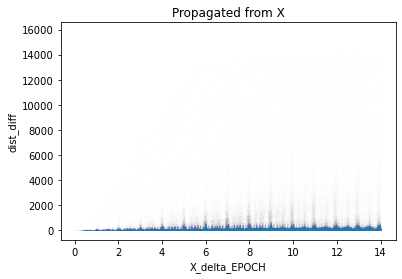

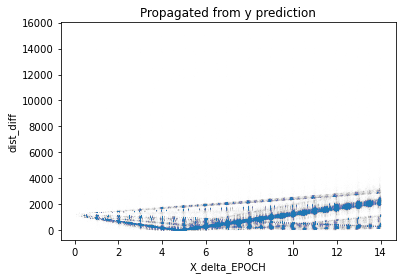

In [9]:
x_diff.plot.scatter(x='X_delta_EPOCH',y='dist_diff',s=0.0001,alpha=0.1,title='Propagated from X')
y_diff.plot.scatter(x='X_delta_EPOCH',y='dist_diff',s=0.0001,alpha=0.1,title='Propagated from y prediction')

(0.0, 14.0)

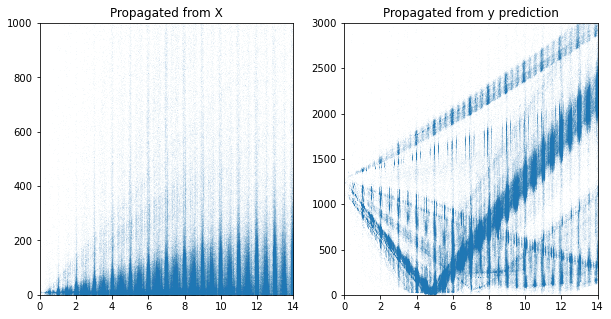

In [24]:
#x_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from X')
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x_diff_sample = x_diff.sample(100000)

ax1.scatter(x=x_diff['X_delta_EPOCH'],y=x_diff['dist_diff'],s=0.01, alpha=0.1)
ax1.set_title('Propagated from X')
ax1.set_ylim(0,1000)
ax1.set_xlim(0,14)

#y_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from y prediction')
ax2.scatter(x=y_diff['X_delta_EPOCH'],y=y_diff['dist_diff'],s=0.01, alpha=0.1)
ax2.set_title('Propagated from y prediction')
ax2.set_ylim(0,3000)
ax2.set_xlim(0,14)


In [10]:
X[['X_INCLINATION_1', 'X_ECCENTRICITY_1', 'X_MEAN_MOTION_1','X_RA_OF_ASC_NODE_1', 'X_ARG_OF_PERICENTER_1', 'X_MEAN_ANOMALY_1','X_BSTAR_1']]

,X_INCLINATION_1,X_ECCENTRICITY_1,X_MEAN_MOTION_1,X_RA_OF_ASC_NODE_1,X_ARG_OF_PERICENTER_1,X_MEAN_ANOMALY_1,X_BSTAR_1
0,0.346109444444,0.2439684,0.284982781714,0.622566666667,0.882507777778,0.105120277778,0.00692640
1,0.346195000000,0.2444256,0.285006766857,0.610089722222,0.883478611111,0.104065833333,0.00487400
2,0.346191666667,0.2438196,0.285074449143,0.576401388889,0.886425000000,0.101568055556,0.00263790
3,0.346188888889,0.2437496,0.285106883429,0.563279722222,0.887556944444,0.100518888889,0.00251870
4,0.346183333333,0.2437832,0.285134531429,0.553012500000,0.888445277778,0.099736388889,0.00250030
...,...,...,...,...,...,...,...
1263166,0.294416111111,0.0042576,0.552256242286,0.129252222222,0.300036111111,0.700573055556,0.00030590
1263167,0.294416111111,0.0042376,0.552526019429,0.122923611111,0.306106666667,0.694496666667,0.00031888
1263168,0.294416111111,0.0042088,0.552854692571,0.115691944444,0.313667500000,0.686928055556,0.00031369
1263169,0.294416666667,0.0041400,0.553278634286,0.106647777778,0.322167500000,0.678415833333,0.00033193


(0.0, 14.0)

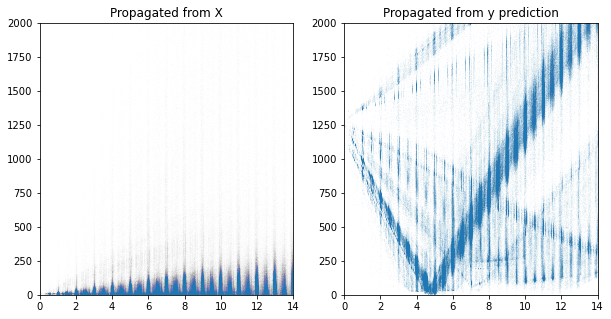

In [32]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x_diff_sample = x_diff.sample(100000)

ax1.scatter(x=x_diff['X_delta_EPOCH'],y=x_diff['dist_diff'],s=0.0001, alpha=0.1)
ax1.set_title('Propagated from X')
ax1.set_ylim(0,2000)
ax1.set_xlim(0,14)

#y_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from y prediction')
ax2.scatter(x=y_diff['X_delta_EPOCH'],y=y_diff['dist_diff'],s=0.0001, alpha=0.5)
ax2.set_title('Propagated from y prediction')
ax2.set_ylim(0,2000)
ax2.set_xlim(0,14)

In [12]:
((x_diff - y_diff).dist_diff>0).value_counts()

False    1192124
True       71047
Name: dist_diff, dtype: int64

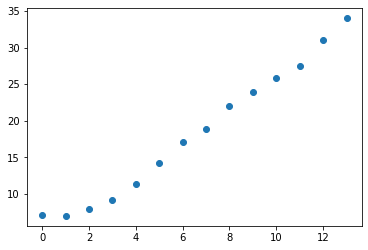

In [13]:
t = x_diff.groupby('bin').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
plt.scatter(t.index, t)

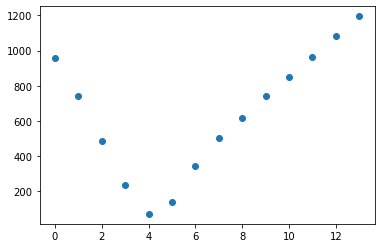

In [14]:
t = y_diff.groupby('bin').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
plt.scatter(t.index, t)

(0.0, 9000.0)

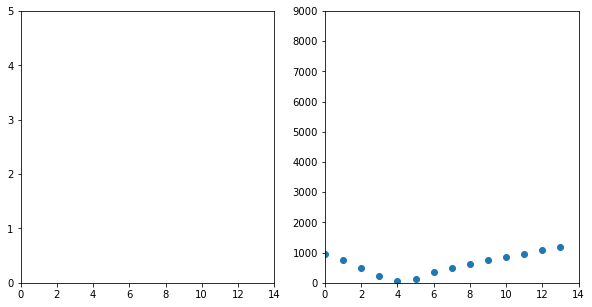

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

t = x_diff.groupby('bin').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
ax1.scatter(t.index, t)

t = y_diff.groupby('bin').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
ax2.scatter(t.index, t)
ax1.set_xlim(0,14)
ax1.set_ylim(0,5)
ax2.set_xlim(0,14)
ax2.set_ylim(0,9000)

In [16]:
x_diff[x_diff.bin == 0][['dist_diff']].describe()

,dist_diff
count,7570.000000000000
mean,28.551381238794
std,236.855741989878
min,0.024931189490
25%,7.903714163705
50%,11.041474631520
75%,15.834892343363
max,13882.286355495080


bin
0     0.003038309115
1     0.008100840336
2     0.015276435246
3     0.053585975923
4     0.124344827586
5     0.088139510453
6     0.056482204844
7     0.048549518533
8     0.045772290638
9     0.050391772772
10    0.050130133663
11    0.052303998522
12    0.054021175476
13    0.048329043114
dtype: float64

<AxesSubplot:title={'center':'Percent time model outperforms SGP4'}, xlabel='bin'>

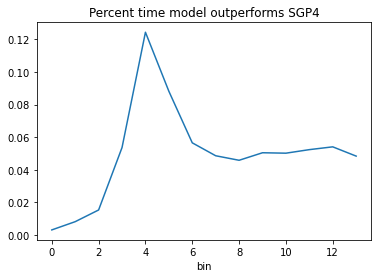

In [17]:
((x_diff - y_diff).dist_diff>0)
tmp = x_diff.copy()
tmp['model_better'] = (x_diff.dist_diff > y_diff.dist_diff)
better_against_epoch_diff = tmp.groupby('bin').apply(lambda x:np.mean(x.model_better))
display(better_against_epoch_diff)
better_against_epoch_diff.plot(title='Percent time model outperforms SGP4')

# X,Y,Z sample4 Tim's Method

In [51]:
import pickle

with open(f'{os.environ["GP_HIST_PATH"]}/../t5_data/sample4__compare_output.pkl', 'rb') as handle:
    data_dict = pickle.load(handle)
# NOTE TLE represented is probably not what you expect (but i dont have time to fix yet)
# ground truth -> X (NOT ground truth TLE)
# baseline -> X
# pred -> predicted Y

In [52]:
def compare(s1,s2):
    s = np.sqrt(((data_dict[s2][['SAT_RX','SAT_RY','SAT_RZ']] - data_dict[s1][['SAT_RX','SAT_RY','SAT_RZ']])**2).sum(axis=1))
    s.name = f'{s2}_error'
    return s


base_error = compare('tle_ground_truth','sgp4_baseline')

pred_error = compare('tle_ground_truth','model_t5_predictions')
compare_df = data_dict['sgp4_baseline'][['EPOCH_DIFF']].merge(base_error, left_index=True, right_index=True)
compare_df = compare_df.merge(pred_error, left_index=True, right_index=True)

print("baseline error")
display(base_error.describe())
print("model error")
display(pred_error.describe())
print("compare")
display(compare_df)


baseline error


count    2.069777000000e+06
mean     5.704325477708e+01
std      3.059898309820e+02
min      3.142536289600e-04
25%      1.268596850526e+00
50%      4.312537784511e+00
75%      1.771661397725e+01
max      2.375984924760e+04
Name: sgp4_baseline_error, dtype: float64

model error


count    2.069777000000e+06
mean     4.313385351485e+02
std      7.838628611859e+02
min      1.171458905918e-01
25%      1.691776959947e+02
50%      2.917713862134e+02
75%      4.640289303953e+02
max      1.552837568004e+04
Name: model_t5_predictions_error, dtype: float64

compare


,EPOCH_DIFF,sgp4_baseline_error,model_t5_predictions_error
0,1.001690209988,0.836934300296,488.788884307165
1,1.001688860012,2.147753829273,366.338886517671
2,1.001686159988,1.548379600648,393.238014114475
3,1.001686330012,3.346929693087,437.595868344800
4,2.003368019988,5.058870643815,417.419825613297
...,...,...,...
2069772,7.836440310000,465.390410916662,366.994870963376
2069773,7.309026610000,515.194004159794,224.168558904788
2069774,7.082984530000,113.195054069990,101.532024428948
2069775,6.932372470000,235.191606984830,169.975858681262


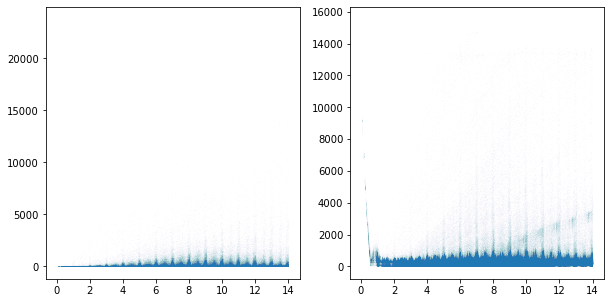

In [53]:
# top_half_baseline = compare_df.groupby('bin').apply(lambda x:np.mean(x.sgp4_baseline_error.nsmallest(len(x)//2)))
# plt.scatter(top_half_baseline.index, top_half_baseline)
# plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.scatter(compare_df.EPOCH_DIFF, compare_df.sgp4_baseline_error, s=0.001, alpha = 0.1)
ax2.scatter(compare_df.EPOCH_DIFF, compare_df.model_t5_predictions_error, s=0.001, alpha = 0.1)
plt.show()

In [61]:
bins=100 #100
labels=[round(v,2) for v in np.linspace(compare_df.EPOCH_DIFF.min(),compare_df.EPOCH_DIFF.max(),bins+1)]
binned=pd.cut(compare_df.EPOCH_DIFF, bins=bins,labels=labels[1:])
compare_df['bin']=binned
compare_df

,EPOCH_DIFF,sgp4_baseline_error,model_t5_predictions_error,bin
0,1.001690209988,0.836934300296,488.788884307165,1.04
1,1.001688860012,2.147753829273,366.338886517671,1.04
2,1.001686159988,1.548379600648,393.238014114475,1.04
3,1.001686330012,3.346929693087,437.595868344800,1.04
4,2.003368019988,5.058870643815,417.419825613297,2.01
...,...,...,...,...
2069772,7.836440310000,465.390410916662,366.994870963376,7.87
2069773,7.309026610000,515.194004159794,224.168558904788,7.31
2069774,7.082984530000,113.195054069990,101.532024428948,7.17
2069775,6.932372470000,235.191606984830,169.975858681262,7.03


In [71]:
# x_mean_diff = compare_df.groupby('bin').apply(lambda x:np.mean(x.sgp4_baseline_error.nsmallest(len(x)//2)))
# x_mean_diff.name = 'mean_diff'
# x_mean_diff = x_mean_diff.reset_index().dropna()

# y_mean_diff = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_t5_predictions_error.nsmallest(len(x)//2)))
# y_mean_diff.name = 'mean_diff'
# y_mean_diff = y_mean_diff.reset_index().dropna()

x_mean_diff = compare_df.groupby('bin').mean()[['sgp4_baseline_error']].reset_index()
x_mean_diff['bin'] = x_mean_diff.bin.astype(float)

y_mean_diff = compare_df.groupby('bin').mean()[['model_t5_predictions_error']].reset_index()
y_mean_diff['bin'] = y_mean_diff.bin.astype(float)

In [72]:
x_mean_diff

,bin,sgp4_baseline_error
0,0.20,0.922466806890
1,0.34,0.582025278471
2,0.48,2.017358191012
3,0.62,3.083504399488
4,0.76,2.292384140296
...,...,...
95,13.44,84.786010289071
96,13.58,105.309536332182
97,13.72,92.010109951042
98,13.86,77.930325854373


Text(0.5, 0, 'Epoch Difference (days)')

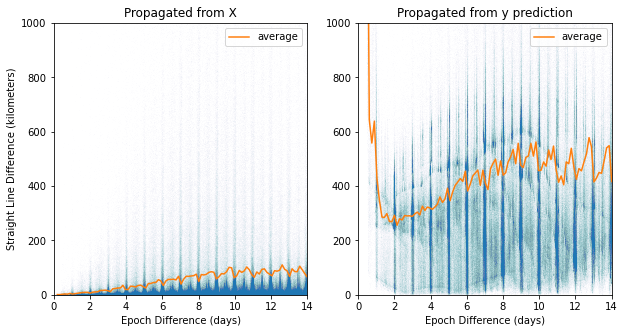

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.scatter(x=compare_df.EPOCH_DIFF,y=compare_df.sgp4_baseline_error,s=0.001, alpha=0.1)
ax1.set_title('Propagated from X')
ax1.set_ylim(0,1000)
ax1.set_xlim(0,14)

#y_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from y prediction')
ax2.scatter(x=compare_df.EPOCH_DIFF,y=compare_df.model_t5_predictions_error,s=0.001, alpha=0.1)
ax2.set_title('Propagated from y prediction')
ax2.set_ylim(0,1000)
ax2.set_xlim(0,14)

# ax1.plot(x_mean_diff.bin, x_mean_diff.mean_diff, label='average',color='tab:orange')
# ax2.plot(y_mean_diff.bin, y_mean_diff.mean_diff, label='average',color='tab:orange')
ax1.plot(x_mean_diff.bin, x_mean_diff.sgp4_baseline_error, label='average',color='tab:orange')
ax2.plot(y_mean_diff.bin, y_mean_diff.model_t5_predictions_error, label='average',color='tab:orange')
ax1.legend(loc=1)
ax2.legend(loc=1)

ax1.set_ylabel('Straight Line Difference (kilometers)')
ax1.set_xlabel('Epoch Difference (days)')
ax2.set_xlabel('Epoch Difference (days)')

bin
0     0.000508259212
1     0.002994230629
2     0.007998294894
3     0.013997977414
4     0.015198171610
5     0.020495024716
6     0.020693002936
7     0.022344147583
8     0.026252579587
9     0.023610957970
10    0.026701038798
11    0.024263736264
12    0.022970081842
13    0.018593616785
dtype: float64

<AxesSubplot:xlabel='bin'>

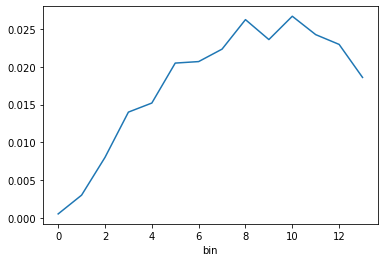

In [38]:
compare_df['bin'] = compare_df['EPOCH_DIFF'].astype(int)
compare_df['model_better'] = (compare_df.sgp4_baseline_error > compare_df.model_t5_predictions_error)
better_against_epoch_diff = compare_df.groupby('bin').apply(lambda x:np.mean(x.model_better))
display(better_against_epoch_diff)
better_against_epoch_diff.plot()

   # Fit Data To Active Model

In [18]:
# df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/secret_test.pkl' )
# try:
#     idx_map = clean_data.load_index_map(name='secret_test', path='data')
# except:
#     idx_map = clean_data.create_index_map(df, write=True, name='secret_test', path='data')
    

In [19]:
from collections import defaultdict
import clean_data

def convert_feature_values(df):
    name = df.name
    df = df.sort_values("EPOCH")
    
    # convert ARG_OF_PERICENTER, RA_OF_ASC_NODE, and MEAN_ANOMALY to non-cyclic version
    df["ARG_OF_PERICENTER_ADJUSTED"] = np.cumsum(np.around(df.ARG_OF_PERICENTER.diff().fillna(0) / -360))*360 + df.ARG_OF_PERICENTER
    df["RA_OF_ASC_NODE_ADJUSTED"] = np.cumsum(np.around(df.RA_OF_ASC_NODE.diff().fillna(0) / -360))*360 + df.RA_OF_ASC_NODE
    
    # according to 18 SPCS there was only 1 such case BUT ITS NOT TRUE there are like 70+
    # this is because for REV_AT_EPOCH = 100,000, it's recorded as 10,000 instead of 0
    # this doesn't handle the case for multiple ground stations reporting though, if the previous is different....
    # would it be better to just remove this as an outlier just to be safe?
    # 90k +- 20 max offset based on MEAN_MOTION maximum from earlier steps
    df.loc[(df.REV_AT_EPOCH==10000) & df.REV_AT_EPOCH.diff().between(-89999,-89940),'REV_AT_EPOCH'] = 0

    # combine REV_AT_EPOCH and MEAN_ANOMALY for a non-cyclic representation
    adjusted_rev = df.REV_AT_EPOCH + np.cumsum(np.around(df.REV_AT_EPOCH.diff().fillna(0) / -100000)) * 100000
    df["REV_MEAN_ANOMALY_COMBINED"] = adjusted_rev * 360 + df.MEAN_ANOMALY
    
    # this is to handle the REV_AT_EPOCH problem inconsistency problem
    # otherwise the REV_MEAN_ANOMALY_COMBINED difference may be incorrect
    # bfill because we may start at non-zero due to previous data removal bit
    a = np.round((adjusted_rev.diff().fillna(method='bfill')/300)).fillna(0)
    df["SUBGROUP"] = np.cumsum(a).astype(int)
    
    doycos, doysin = cyclic_repr(df.EPOCH.dt.dayofyear, 366)
    df["DAY_OF_YEAR_COS"] = doycos
    df["DAY_OF_YEAR_SIN"] = doysin
    
    macos, masin = cyclic_repr(df.MEAN_ANOMALY, 360)
    df["MEAN_ANOMALY_COS"] = macos
    df["MEAN_ANOMALY_SIN"] = masin
    
    icos, isin = cyclic_repr(df.INCLINATION, 360)
    df["INCLINATION_COS"] = icos
    df["INCLINATION_SIN"] = isin
    
    rcos, rsin = cyclic_repr(df.RA_OF_ASC_NODE, 360)
    df["RA_OF_ASC_NODE_COS"] = rcos
    df["RA_OF_ASC_NODE_SIN"] = rsin
    
    df[['EPOCH_JD', 'EPOCH_FR']] = df.EPOCH.apply(__jday_convert).to_list()
    return df

def cyclic_repr(s,v,reverse=False):
    if not reverse:
        cos = np.cos(np.deg2rad(s * (360/v)))
        sin = np.sin(np.deg2rad(s * (360/v)))
        return cos,sin
    else:
        if isinstance(s, pd.DataFrame):
            cos_vals=s.iloc[:,0]
            sin_vals=s.iloc[:,1]
        elif s.shape[1]==2:
            cos_vals=s[:,0]
            sin_vals=s[:,1]
        else:
            cos_vals=s[0]
            sin_vals=s[1]
        return np.rad2deg(np.arcsin(sin_vals) + np.arccos(cos_vals))/2

def do_the_thing(df, f):
    df = df.groupby(by="NORAD_CAT_ID", as_index=False).progress_apply(convert_feature_values)
    df = df.merge(sgp4_data[f], left_index=True, right_index=True)
    df = df.merge(tle_sup_data[f], left_on="GP_ID", right_index=True)
    df = df.groupby(["NORAD_CAT_ID","SUBGROUP"], as_index=False).progress_apply(generate_X_y)
    df.reset_index(drop=True, inplace=True)
    return df

# dataset = "secret_test"

# # using defaultdict to lazy load dataframes.... probably should stay in notebook as shortcut only
# data = defaultdict(lambda: pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/{dataset}.pkl"))
# tle_sup_data = defaultdict(lambda: pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../tle_sup/{dataset}.pkl"))
# sgp4_data = defaultdict(lambda: pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/{dataset}_sgp4rv.pkl"))

# df = do_the_thing(data, dataset)

In [ ]:
# df = pd.read_pickle(f'data/x_test1.pkl')

In [ ]:
# df.head()

In [ ]:
# df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/../3_min/secret.pkl' )
# df

In [ ]:
# df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/secret_sgp4rv.pkl")
# df

In [ ]:
# df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../tle_sup/secret_test.pkl")
# df

In [ ]:
# clean_data.build_xy